In [4]:
import numpy as np 
import spacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
from nltk.corpus import stopwords
import nltk
import heapq
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

stopwords = stopwords.words('english')
sns.set_context('notebook')

In [5]:
reviews = pd.read_csv(r"C:\Users\LAPPY SHOP\Desktop\Text Summarization using Spacy\winemag-data-130k-v2.csv", nrows=5000,usecols =['points', 'title', 'description'],encoding='latin1')
reviews = reviews.dropna()
reviews.head(15)

,description,points,title
0,"Aromas include tropical fruit, broom, brimston...",87,Nicosia 2013 VulkÃ Bianco (Etna)
1,"This is ripe and fruity, a wine that is smooth...",87,Quinta dos Avidagos 2011 Avidagos Red (Douro)
2,"Tart and snappy, the flavors of lime flesh and...",87,Rainstorm 2013 Pinot Gris (Willamette Valley)
3,"Pineapple rind, lemon pith and orange blossom ...",87,St. Julian 2013 Reserve Late Harvest Riesling ...
4,"Much like the regular bottling from 2012, this...",87,Sweet Cheeks 2012 Vintner's Reserve Wild Child...
5,Blackberry and raspberry aromas show a typical...,87,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...
6,"Here's a bright, informal red that opens with ...",87,Terre di Giurfo 2013 Belsito Frappato (Vittoria)
7,This dry and restrained wine offers spice in p...,87,Trimbach 2012 Gewurztraminer (Alsace)
8,Savory dried thyme notes accent sunnier flavor...,87,Heinz Eifel 2013 Shine GewÃ¼rztraminer (Rheinh...
9,This has great depth of flavor with its fresh ...,87,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...


In [6]:
nlp = spacy.load('en_core_web_lg')
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>©', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")

In [7]:
reviews['description_Cleaned_1'] = reviews['description'].apply(normalize_text)

In [9]:
print('Before normalizing text-----\n')
print(reviews['description'][3])
print('\nAfter normalizing text-----\n')
print(reviews['description_Cleaned_1'][3])

Before normalizing text-----

Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.

After normalizing text-----

Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.


In [10]:
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~©'

def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)
reviews['Description_Cleaned'] = reviews['description_Cleaned_1'].apply(lambda x: cleanup_text(x, False))

In [11]:
print('Reviews description with punctuatin and stopwords---\n')
print(reviews['description_Cleaned_1'][0])
print('\nReviews description after removing punctuation and stopwrods---\n')
print(reviews['Description_Cleaned'][0])

Reviews description with punctuatin and stopwords---

Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.

Reviews description after removing punctuation and stopwrods---

aroma include tropical fruit broom brimstone dry herb . palate overly expressive offer unripene apple citrus dry sage alongside brisk acidity .


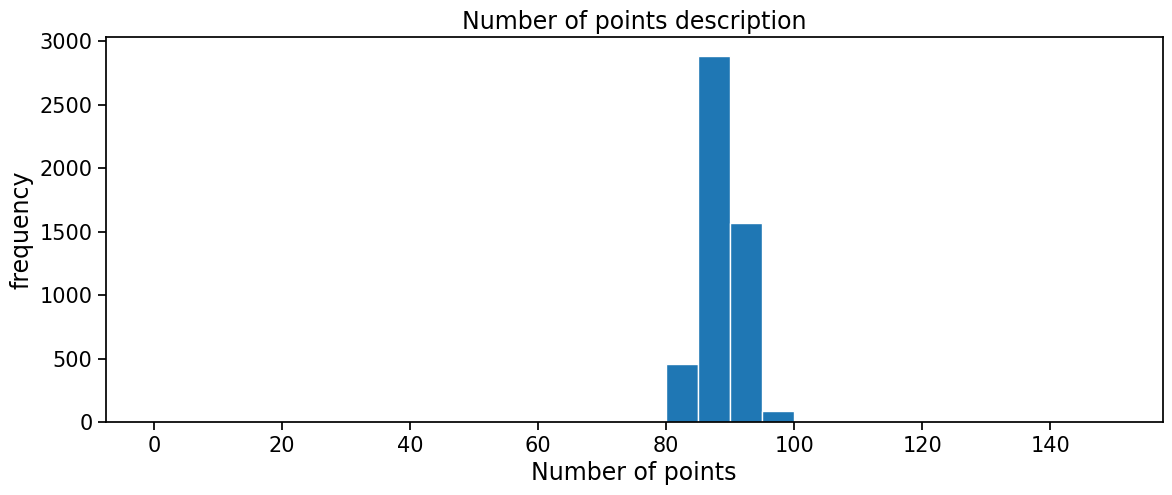

In [12]:
plt.subplot(1, 2, 1)
(reviews['points']).plot.hist(bins=30, figsize=(30,5), edgecolor='white',range=[0,150])
plt.xlabel('Number of points', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Number of points description', fontsize=17)
plt.show()

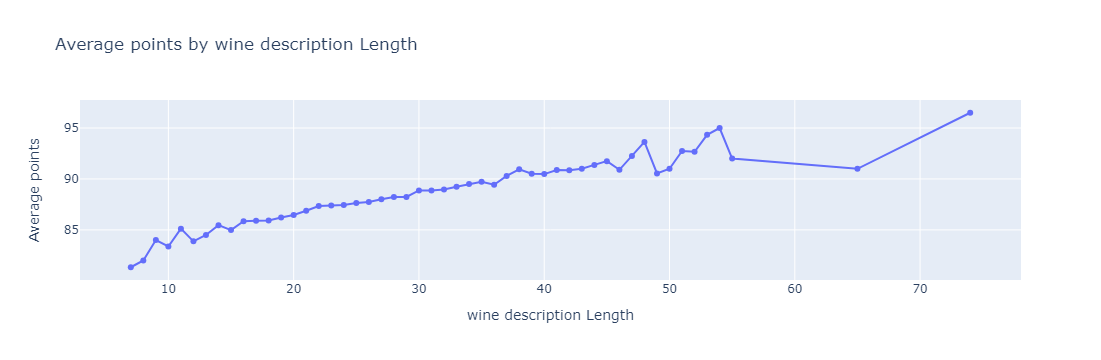

In [13]:
reviews['Title_len'] = reviews['Description_Cleaned'].str.split().str.len()
rev = reviews.groupby('Title_len')['points'].mean().reset_index()
trace1 = go.Scatter(
    x = rev['Title_len'],
    y = rev['points'],
    mode = 'lines+markers',
    name = 'lines+markers'
)
layout = dict(title= 'Average points by wine description Length',
              yaxis = dict(title='Average points'),
              xaxis = dict(title='wine description Length'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [14]:
def generate_summary(text_without_removing_dot, cleaned_text):
    sample_text = text_without_removing_dot
    doc = nlp(sample_text)
    sentence_list=[]
    for idx, sentence in enumerate(doc.sents): # we are using spacy for sentence tokenization
        sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))

    stopwords = nltk.corpus.stopwords.words('english')

    word_frequencies = {}  
    for word in nltk.word_tokenize(cleaned_text):  
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1


    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)


    sentence_scores = {}  
    for sent in sentence_list:  
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]


    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)
    print("Original Text:\n")
    print(text_without_removing_dot)
    print('\n\nSummarized text:\n')
    print(summary)  

In [15]:
generate_summary(reviews['description_Cleaned_1'][8], reviews['Description_Cleaned'][8])

Original Text:

Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint.


Summarized text:

Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk offdry wine Its fruity and fresh with an elegant sprightly footprint


In [16]:
generate_summary(reviews['description_Cleaned_1'][100], reviews['Description_Cleaned'][100])

Original Text:

Fresh apple, lemon and pear flavors are accented by a hint of smoked nuts in this bold, full-bodied Pinot Gris. Rich and a bit creamy in mouthfeel yet balanced briskly, it's a satisfying white with wide pairing appeal. Drink now through 2019.


Summarized text:

Rich and a bit creamy in mouthfeel yet balanced briskly its a satisfying white with wide pairing appeal Fresh apple lemon and pear flavors are accented by a hint of smoked nuts in this bold fullbodied Pinot Gris Drink now through 2019


In [17]:
generate_summary(reviews['description_Cleaned_1'][500], reviews['Description_Cleaned'][500])

Original Text:

Aromas of watermelon and a dusting of natural vanilla mark the bouquet. On the palate, it's fleshy but still crisp and focused, with nectarine, red apple and strawberry flavors. The finish lasts, with some sweetness.


Summarized text:

On the palate its fleshy but still crisp and focused with nectarine red apple and strawberry flavors Aromas of watermelon and a dusting of natural vanilla mark the bouquet The finish lasts with some sweetness
